# **Industries of the S&P 500**

## Introduction

In this project I am analysing historical stock data of the companies that are or were listed in the S&P 500. I am especially interested in the performance of different industries represented in the index. Through the analysis of past stock movements, I attempt to formulate general investment advice for the present and future, regarding different industries.

The S&P 500, or Standard and Poor's 500, is a stock market index that contains the 500 largest companies listed on stock exchanges in the USA. That is around 80% of the market capitalization which equals 42 trillion USD. The index was founded in 1957 and is managed by S&P Dow Jones Indices LLC. The components of the S&P 500 are selected by a committee, based on different criteria like market capitalization, monthly traded shares and company listing location.

For the project, I used two datasets, first a list of all companies currently in the S&P 500 and secondly the historical stock data of each company.

#### 1. Company List
- **File name:** sp500_companies.csv  
- **Source:** https://en.wikipedia.org/wiki/List_of_S%26P_500_companies  
- **Collected by**: various Wikipedia editors  
- **When was the data collected:** constantly updated  
- **When was the data downloaded:** 18.12.2023  
- **Purpose of data collection:** providing free and easy access to data / no special purpose
- **License:** No license
- **Information:**
- **Description:** Dates are in yy-mm-dd format
    - Shape: 503, 8
    - Features: 
        - Symbol (Categorical, String): Stock ticker symbol
        - Security (Categorical, String): Company name
        - GICS Sector (Categorical, String): Industry
        - GICS Sub-Industry (Categorical, String): Sub-industry
        - Headquarters Location (Categorical, String): City and State where the HQ is
        - Date Added (Continuous, Date): When the company was added to the S&P 500
        - CIK (Categorical, Integer): Central Index Key, ID for companies
        - Founded (Categorical, Integer): Year of incorporation

#### 2. Historical Stock Data
- **File name:** _symbol_\_data.csv (506 individual files, one for each company) 
- **Source:** https://www.kaggle.com/datasets/camnugent/sandp500 
- **Collected by**: Cam Nugent  
- **When was the data collected:** February 2018 
- **When was the data downloaded:** 18.12.2023 
- **Purpose of data collection:** providing a large and well structured financial dataset for analysis and visualization
- **License:** No license
- **Information**: The following features were captured once a day from 2013-02-08 to 2018-02-07 for each stock, prices are in USD, Dates are in yy-mm-dd format
- **Description:** 
    - Shape: 1259, 7
    - Features: 
        - date (Continuous, Date): Date of capture
        - open (Continuous, Float): Opening price
        - high (Continuous, Float): Highest price
        - low (Continuous, Float): Lowest price
        - close (Continuous, Float): Closing price
        - volume (Continuous, Integer): Number of shares traded
        - Name (Categorical, String): Stock ticker symbol

#### 3. SSE Composite Index
- **File name:** SCI.csv 
- **Source:** https://finance.yahoo.com/quote/000001.SS/history?period1=1360281600&period2=1517961600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
- **Collected by**: Yahoo! Finance  
- **When was the data collected:** constantly updated
- **When was the data downloaded:** 20.01.2023 
- **Purpose of data collection:** provide a free and public dataset to profesionals, researchers and interested people
- **License:** No license
- **Information**:
- **Description:** 
    - Shape: 1826, 7
    - Features: 
        - Date (Continuous, Date): Date of price
        - Open (Continuous, Float): Opening price
        - High (Continuous, Float): Highest price
        - Low (Continuous, Float): Lowest price
        - Close (Continuous, Float): Closing price
        - Adj Close (Continuous, Float): Adjusted closing price
        - Volume (Categorical, Integer): Number of shares traded


## Research Question

#### *How does the risk and return profile vary across different industries in the stock market, and can industrie-specific patterns be identified to inform investment decisions?*

#### Sub-Questions

1. What industry in the S&P 500 had the highest average return while having the lowest risk?
2. Can any repeating patterns or special events by identified in the price data of the individual industries?
3. What is the top performing company in each industry?

(How has the share of the individual industries in the S&P 500 changed over time?,
(Are individual companies responsible for most of the return or does every company approximately contribute equally?))

## Preparations

In this part, I do some initial preparations to enable the analysis.

#### 1. Groundwork

In [27]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats

In [2]:
# define color palatte to be used throughout the analysis
industry_colors = {
    "Industrials": "steelblue",
    "Financials": "darkorange",
    "Health Care": "mediumseagreen",
    "Information Technology": "indianred",
    "Consumer Discretionary": "mediumpurple",
    "Consumer Staples": "goldenrod",
    "Real Estate": "cornflowerblue",
    "Utilities": "tomato",
    "Materials": "darkslategray",
    "Energy": "darkolivegreen",
    "Communication Services": "slateblue",
}

In [3]:
def fill_missing_rows(file_path, output_dir):
    """
    Fill weekend days in with interpolated data.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(
        file_path,
        parse_dates=[0],
        header=0,
        names=["date", "open", "high", "low", "close", "volume", "Name"],
        dtype={
            "open": float,
            "high": float,
            "low": float,
            "close": float,
            "volume": int,
            "Name": str,
        },
    )

    # Convert the 'Date' column to datetime
    df["date"] = pd.to_datetime(df["date"])

    # Create a date range covering the full period of the data
    full_date_range = pd.date_range(df["date"].min(), df["date"].max(), freq="D")

    # Reindex the DataFrame to include all dates in the range
    df = df.set_index("date").reindex(full_date_range).reset_index()

    # Fill missing values with the mean of the surrounding values
    df["open"] = df["open"].interpolate().round(2)
    df["high"] = df["high"].interpolate().round(2)
    df["low"] = df["low"].interpolate().round(2)
    df["close"] = df["close"].interpolate().round(2)
    df["volume"] = df["volume"].interpolate().round().astype(int)

    df["Name"].fillna(df["Name"][0], inplace=True)

    # Save the filled DataFrame to a new CSV file
    output_file = os.path.join(output_dir, os.path.basename(file_path))
    df.to_csv(output_file, index=False)


def fill_missing_rows_in_directory(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each CSV file in the input directory
    for file_name in tqdm(os.listdir(input_dir)):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_dir, file_name)
            fill_missing_rows(file_path, output_dir)

In [4]:
input_directory = "data/historical_stock_data/individual_stocks_5yr/"
output_directory = "data/historical_stock_data/complete_dates_individual_stocks_5yr/"

fill_missing_rows_in_directory(input_directory, output_directory)

  0%|          | 2/506 [00:00<00:33, 15.02it/s]

100%|██████████| 506/506 [00:51<00:00,  9.91it/s]


#### 2. Feature Engineering

In [5]:
# creating some useful variables
sp500_companies = pd.read_csv("data/company_list/sp500_companies.csv")
num_stocks = len(sp500_companies)
industries = sp500_companies["GICS Sector"].unique()

dir_path_hist_data = "data/historical_stock_data/complete_dates_individual_stocks_5yr/"

In [6]:
def calc_avg_return(closing_prices: pd.Series) -> np.float64:
    """
    Function to calculate the average daily return over a series of closing prices.

    Args:
        closing_prices (pd.Series): Series of daily closing prices
    Return:
        np.mean(daily_return) (float): Mean of all daily returns
    """

    daily_return = np.diff(closing_prices)
    return np.mean(daily_return)

In [174]:
"""
Cell Content:
1. Expand sp500_companies.csv to include average return and standard deviation (volatility) of each stock
2. Calculate avg closing price (over companies) sequence for every industry
"""

avg_return = []
std_dev = []
company_name = []

all_closing_prices = [
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
]  # all closing prices, can not be np array because different industries have different amount of companies, structure: (industry, company, closing price at day x)

avg_closing_price_industry = np.empty(
    (11, 1826)
)  # sequence of daily closing prices averaged over companies (11 industries, 1826 days of data capture)

industry_index = {
    "Industrials": 0,
    "Financials": 1,
    "Health Care": 2,
    "Information Technology": 3,
    "Consumer Discretionary": 4,
    "Consumer Staples": 5,
    "Real Estate": 6,
    "Utilities": 7,
    "Materials": 8,
    "Energy": 9,
    "Communication Services": 10,
}  # map industry name to index

for file_name in tqdm(
    os.listdir(dir_path_hist_data)
):  # loop through all files with historical stock data
    if file_name.endswith(".csv"):
        # preparing dataframe extension
        file_path = os.path.join(dir_path_hist_data, file_name)  # create file path
        hist_data = pd.read_csv(file_path)  # read file with historical data
        symbol = hist_data["Name"][0]  # extract symbol
        closing_prices = hist_data["close"]  # extract closing prices
        avg_return.append(calc_avg_return(closing_prices))  # calc avg return
        std_dev.append(
            (np.std(closing_prices) / np.mean(closing_prices)) * 100
        )  # calc std dev in percent
        company_name.append(symbol)  # store company name to merge on this column

        # calculating avg daily closing prices
        company = sp500_companies[
            sp500_companies["Symbol"] == symbol
        ]  # get company data from dataset 1 (Company List)
        if company.empty:  # if no entry found continue
            continue
        industry_name = company["GICS Sector"].values[0]  # extract industry of company
        ind = industry_index[industry_name]  # obtain correct index through index dict
        all_closing_prices[ind].append(
            closing_prices.tolist()
        )  # add closing prices of the company to closing price list of the industry (index ind)

for ind, industry in enumerate(all_closing_prices):  # loop over industries
    industry = [
        company for company in industry if len(company) == 1826
    ]  # remove companies that have insufficient data (<~1%)
    industry_np = np.array(
        industry
    )  # convert to np array because I want to use vectorization
    for entry_ind in range(len(industry_np[0])):  # loop over daily closing prices
        mean = np.mean(
            industry_np[:, entry_ind]
        )  # calculate mean over all companies in industry
        avg_closing_price_industry[
            ind, entry_ind
        ] = mean  # store mean in numpy array for later use

expansion_df = pd.DataFrame(
    {"Avg_return": avg_return, "Std_dev": std_dev, "Symbol": company_name}
)  # create new df

sp500_companies_extended = pd.merge(
    sp500_companies, expansion_df, on="Symbol", how="left"
)  # merge stocks df with new dataframe to obtain extended df


  0%|          | 0/505 [00:00<?, ?it/s]

100%|██████████| 505/505 [00:13<00:00, 36.83it/s]


## Analysis

This analysis focuses on the different industries of the S&P 500. The index consists of 11 different industries. These are Industrials, Financials, Health Care, Information Technology, Consumer Discretionary, Consumer Staples, Real Estate, Utilities, Materials, Energy and Communication Services. These industries are further divided into sub-industries which I will ignore in this analysis. Every industry has a different number of companies associated with it and a different total market capitalization. The industries are defined by the Global Industry Classification Standard (GICS), developed 1999 by S&P Global and MSCI. The classification system consists of 11 industry classes, called sectors. Every public company can be classified in one of these classes.

#### 1. Visual Overview

In this part, I present an initial chart to provide the reader with a better understanding of the used datasets. This chart is not directly related to the research questions.

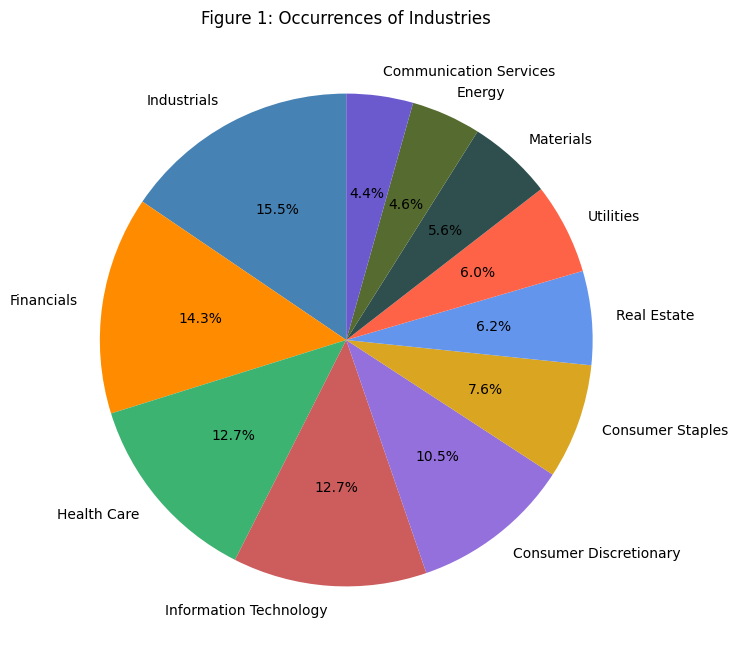

In [175]:
# creating and plotting figure
industries_occ = sp500_companies["GICS Sector"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(
    industries_occ,
    labels=industries_occ.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=industry_colors.values(),
)
plt.title("Figure 1: Occurrences of Industries")
plt.show()

In this pie chart, we can see the relativ number of occurances of stocks from each industry. The S&P 500, at the time of download of the dataset, consisted mainly of stocks from the industrials industry, with around 15.5%. Companies from this industry are for example Honeywell, Lockheed Martin and 3M. The next biggest groups of stocks is from the financials industry with around 14.3%. Known companies from this industry include Visa, Mastercard and Berkshire Hathaway. On the lower end of the spectrum we have industries like the materials industry with around 5.6% of all stocks, the energy industry at around 4.6% and the communication services industry at 4.4%.

#### 2. Sub-question 1: What industry in the S&P 500 had the highest average return while having the lowest risk?

Here I want to identify the industry with the biggest return as well as the industry with the lowest risk over the whole 5-year time frame. I define the risk of a stock with its volatility. Stocks with higher volatility tend to have larger price fluctuations. I calculate the volatility using the standard variance of a price sequence. The return is simply defined as the gain or loss made on an potential investment relative to its initial cost.

In [176]:
def scatter_plot_stocks(
    stocks: pd.DataFrame, color_palatte: dict
) -> None:  # function to generate scatter plots, based on return and risk data
    plt.figure(figsize=(10, 6))

    for (
        industry_name,
        color,
    ) in color_palatte.items():  # loop over industries and colors
        stock_data = stocks[stocks["GICS Sector"] == industry_name]
        avg_return_percent = stock_data["Avg_return"] * 100
        plt.scatter(
            avg_return_percent,  # return
            stock_data["Std_dev"],  # risk
            label=industry_name,
            alpha=0.7,
            color=color,  # Use the color directly from industry_colors
            s=30,
        )  # create scatter plot

    # plot
    plt.title("Figure 2: Scatter Plot of Average Return vs. Standard Deviation by Industry")
    plt.xlabel("Average Return in percent")
    plt.ylabel("Standard Deviation (Volatility) in percent")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [177]:
def scatter_plot_stocks_interactive(stocks: pd.DataFrame, color_palette: dict) -> None:
    fig = px.scatter(
        stocks,
        x=stocks["Avg_return"] * 100,  # x-axis (return)
        y="Std_dev",  # y-axis (risk)
        color="GICS Sector",  # color by industry
        symbol="GICS Sector",  # use different symbols for each industry
        labels={"Avg_return": "Average Return in percent", "Std_dev": "Standard Deviation (Volatility) in percent"},
        title="Scatter Plot of Average Return vs. Standard Deviation by Industry",
        size_max=10,
        opacity=0.7,
        color_discrete_map=color_palette
    )

    fig.show()

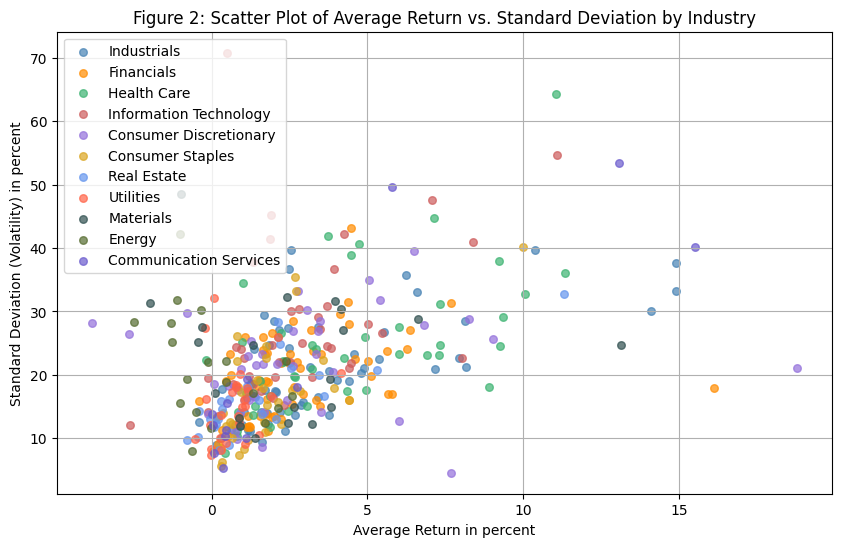

In [178]:
# outlier removal for better plotting results
filtered_sp500_companies_extended = (
    sp500_companies_extended.copy()
)  # copy dataset for outlier removal

# Define conditions for filtering
condition_avg_return = (
    filtered_sp500_companies_extended["Avg_return"] <= 0.2
)  # filter out companies with avg return higher than 20%

condition_std_dev = (
    filtered_sp500_companies_extended["Std_dev"] <= 100
)  # filter out companies with std dev higher than 100

# Apply the conditions and keep only rows that satisfy both conditions
filtered_sp500_companies_extended = filtered_sp500_companies_extended[
    condition_avg_return & condition_std_dev
]

scatter_plot_stocks(filtered_sp500_companies_extended, industry_colors)
scatter_plot_stocks_interactive(filtered_sp500_companies_extended, industry_colors)

In this plot we can see the distribution of almost all S&P 500 companies (some removed feature engineering and some by outlier removal) regarding their volatility and average return over the whole time frame of 5 years, colorcoded by industry. The standard deviation and the return are expressed in percentage. We can see that a significant amount of companies have generated a negative return. We can also see that generally risk rises with return. That confirms the "No Free Lunch Theorem" that says that there is always a trade-off between risk and return. Of course there are still some outlieres for example two companies from the Consumer Discretionary industry that had a high average return of aroudn 10% while having a relatively low volatility of also around 10%. At the same time there are other companies that have a high volatility with negative return. We can also observe that the majority of the companies neither had a high volatility or high returns. From this chart it is difficult to see which industry performed the best so some further exploration is necessary.

In [179]:
industry_stats = (
    sp500_companies_extended.groupby("GICS Sector")
    .agg({"Avg_return": "mean", "Std_dev": "std"})
    .reset_index()
)

industry_stats["Avg_return_normalized"] = (
    industry_stats["Avg_return"] - industry_stats["Avg_return"].min()
) / (industry_stats["Avg_return"].max() - industry_stats["Avg_return"].min())
industry_stats["Std_dev_normalized"] = (
    industry_stats["Std_dev"] - industry_stats["Std_dev"].min()
) / (industry_stats["Std_dev"].max() - industry_stats["Std_dev"].min())

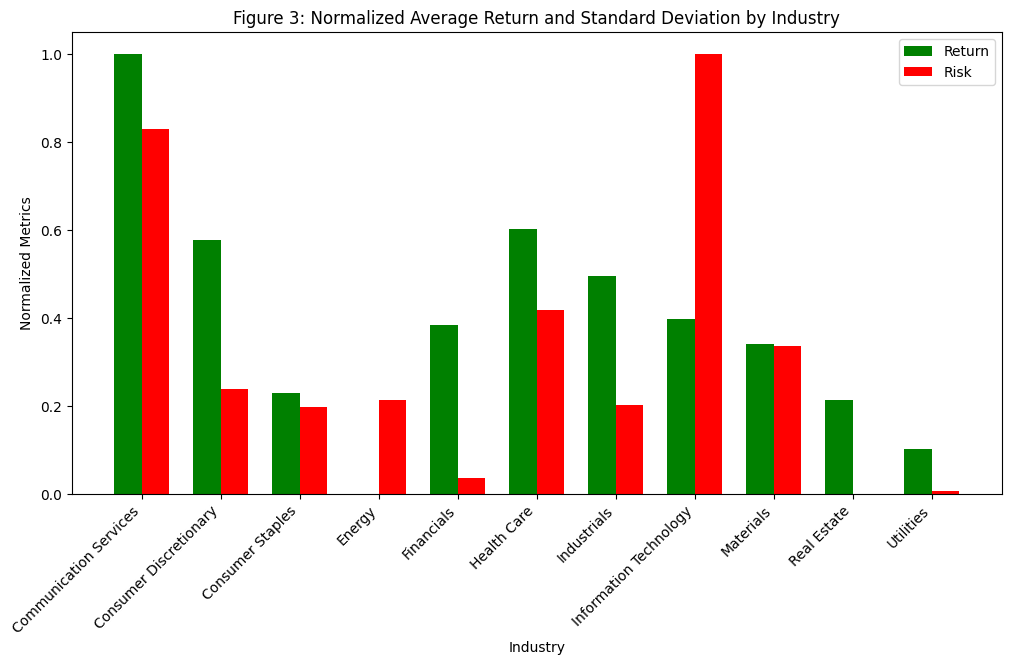

In [180]:
plt.figure(figsize=(12, 6))

bar_width = 0.35  # Width of each bar

# Create numerical positions for each industry
industries = np.arange(len(industry_stats["GICS Sector"]))

# Bar graph for Normalized Average Return
plt.bar(
    industries,
    industry_stats["Avg_return_normalized"],
    width=bar_width,
    label="Return",
    color="green",
)

# Bar graph for Normalized Standard Deviation
plt.bar(
    industries + bar_width,
    industry_stats["Std_dev_normalized"],
    width=bar_width,
    label="Risk",
    color="red",
)

# Set x-axis ticks to industry names
plt.xticks(
    industries + bar_width / 2, industry_stats["GICS Sector"], rotation=45, ha="right"
)

plt.title("Figure 3: Normalized Average Return and Standard Deviation by Industry")
plt.xlabel("Industry")
plt.ylabel("Normalized Metrics")
plt.legend()

plt.show()

In this chart we can see the overall risk and return associated with the different industries. I decided here to keep the whole data without the filtering applied, as for the scatter plot above. The reason for this is that in a industry focused investment scenario, it would be likely to invest into an asset like an Exchange Traded Fund (ETF), that includes all companies found in the industry. Using the filtered data beares a significantly different result. We see that Communication Services was the industry with the highest returns (and also high risk), while Information Technology was the industry with the highest risk. The energy industry had virtually no benefit for investors, while Real Estate and Utilites had the best return to risk ratios. However the return in these industries was rather low. The Financials industry looks the most promising with a relatively high return and a low risk. In the next chart I am combining the return and risk metric to be able to clearly distinguish the best industry.

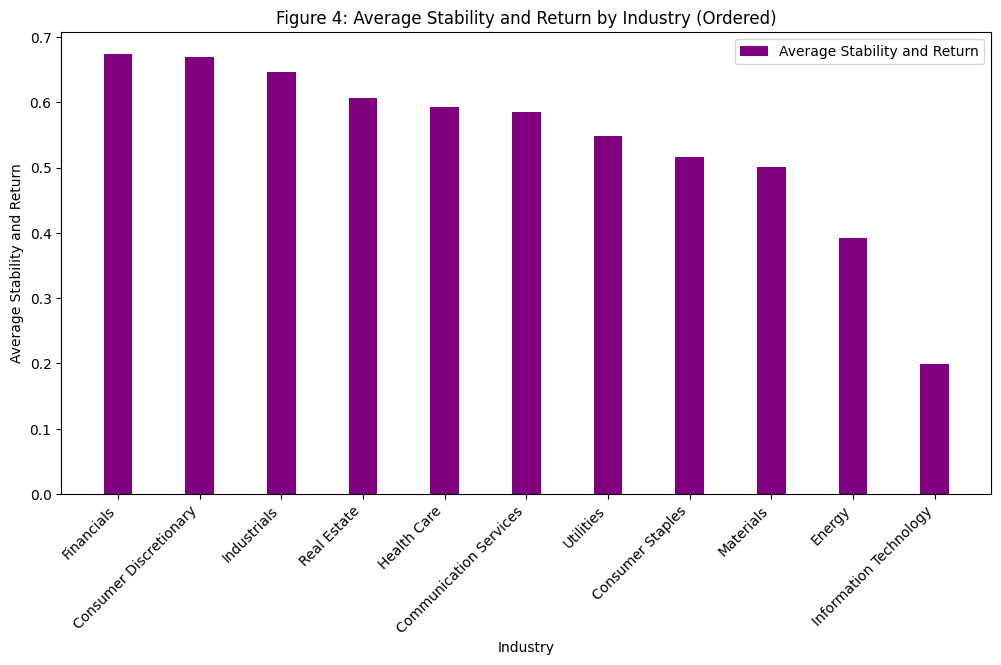

In [181]:
industry_stats["Stability"] = (
    1 - industry_stats["Std_dev_normalized"]
)  # calc stability score out of volatility

# Calculate the average of stability and return
industry_stats["Average_Stability_Return"] = (
    industry_stats["Stability"] + industry_stats["Avg_return_normalized"]
) / 2

# Sort the DataFrame by 'Average_Stability_Return' in descending order
industry_stats = industry_stats.sort_values(
    by="Average_Stability_Return", ascending=False
)

plt.figure(figsize=(12, 6))

bar_width = 0.35  # Width of each bar

# Create numerical positions for each industry
industries = np.arange(len(industry_stats["GICS Sector"]))

# Bar graph for Average Stability and Return
plt.bar(
    industries,
    industry_stats["Average_Stability_Return"],
    width=bar_width,
    label="Average Stability and Return",
    color="purple",
)

# Set x-axis ticks to industry names
plt.xticks(industries, industry_stats["GICS Sector"], rotation=45, ha="right")

# plot
plt.title("Figure 4: Average Stability and Return by Industry (Ordered)")
plt.xlabel("Industry")
plt.ylabel("Average Stability and Return")
plt.legend()

plt.show()

Looking at this chart we can clearly answer the first sub question with "Financials". In the time frame from 2013 to 2018 the Financials industry was the overall best to invest in and the Information Technology the overall worst when defining the metric "best" as the average of return and stability of an industry. Consumer Discretionary is close second to Financials and Industrials comes in third. Materials and Energy are situated before Information Technology at the lower end of the chart.

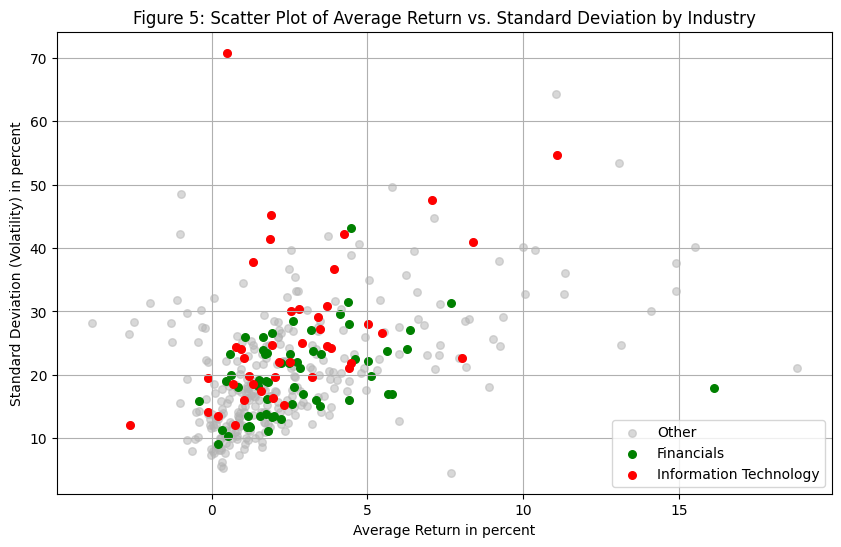

In [182]:
plt.figure(figsize=(10, 6))

other_data = filtered_sp500_companies_extended[
    filtered_sp500_companies_extended["GICS Sector"] != "Financials"
]
avg_return_percent_other = other_data["Avg_return"] * 100
plt.scatter(
    avg_return_percent_other,
    other_data["Std_dev"],
    label="Other",
    alpha=0.5,
    c=[[0.7, 0.7, 0.7]],
    s=30,
)

financials_data = filtered_sp500_companies_extended[
    filtered_sp500_companies_extended["GICS Sector"] == "Financials"
]
avg_return_percent_financials = financials_data["Avg_return"] * 100
plt.scatter(
    avg_return_percent_financials,
    financials_data["Std_dev"],
    label="Financials",
    alpha=1,
    c=["green"],
    s=30,
)

IT_data = filtered_sp500_companies_extended[
    filtered_sp500_companies_extended["GICS Sector"] == "Information Technology"
]
avg_return_percent_IT = IT_data["Avg_return"] * 100
plt.scatter(
    avg_return_percent_IT,
    IT_data["Std_dev"],
    label="Information Technology",
    alpha=1,
    c=["red"],
    s=30,
)

plt.title("Figure 5: Scatter Plot of Average Return vs. Standard Deviation by Industry")
plt.xlabel("Average Return in percent")
plt.ylabel("Standard Deviation (Volatility) in percent")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

To conclude this part, we can look at the scatter plot again with only the companies from the financial industry (best performing) and from the IT industry (worst performing) highlighted. Just with this visual information it is not clearly visible whether the Financials industry is actually the best and the IT industry is acutally the worst industry. However it is still interesting to see.

#### 3. Sub-question 2: Can any repeating patterns or special events by identified in the price data of the individual industries?

This part is focused on analyzing the time component of the data which has not been explored in the previous part. The analysis attempts to uncover patterns and significant points in the price development of the different industries. Maybe it is possible to link unusual behaviour in the price charts to special events that occured during that time and may have taken an influence on the stock prices.

In [183]:
def plot_line_chart(y_axis_data, x_axis_data):
    # Plot stock prices for each company
    plt.figure(figsize=(10, 6))

    for ind, industry in enumerate(industry_colors.keys()):
        plt.plot(
            x_axis_data,
            y_axis_data[ind],
            label=industry,
            color=industry_colors[industry],
        )

    # Format x-axis as dates
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability

    plt.title("Figure 6: Average Stock Prices Over Time for Each Industry")
    plt.xlabel("Time")
    plt.ylabel("Average Industry Stock Price in USD")
    plt.legend()
    plt.show()

In [184]:
def plot_interactive_line_chart(y_axis_data, x_axis_data):
    fig = go.Figure()

    # Plot stock prices for each company
    for ind, industry in enumerate(industry_colors.keys()):
        fig.add_trace(go.Scatter(
            x=x_axis_data,
            y=y_axis_data[ind],
            mode='lines',
            name=industry,
            line=dict(color=industry_colors[industry]),
        ))

    # Format x-axis as dates
    fig.update_xaxes(type='date')

    # Layout settings
    fig.update_layout(
        title="Average Stock Prices Over Time for Each Industry",
        xaxis_title="Time",
        yaxis_title="Average Industry Stock Price in USD",
        legend=dict(title="Industry"),
        xaxis=dict(
            tickmode='auto',
            tickangle=45,
            nticks=10,
            tickformat="%Y-%m-%d",
        ),
    )

    # Show the interactive plot
    fig.show()

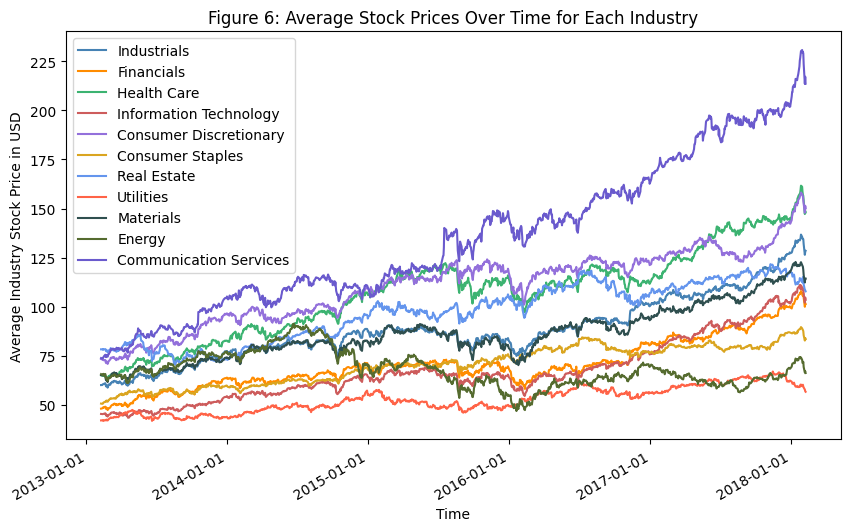

In [185]:
time = np.arange(1826)
start_date = datetime.strptime("2013-02-08", "%Y-%m-%d")
dates = [start_date + timedelta(days=i) for i in range(1826)]

plot_line_chart(avg_closing_price_industry, dates)
plot_interactive_line_chart(avg_closing_price_industry, dates)

The first thing we can see is that the general trend over the whole time frame is that the average stock price of the different industries increased for almost every industry. The average stock price in the Communication Services industry was the highest for almost the whole time frame, while Utilities had the lowest average stock price. Also to strongest increase in price happened in tne Communication Services industry. Only the energy industry seems to have delivered almost no return over the whole time frame. All this can be also seen in the graph "Normalized Average Return and Standard Deviation by Industry". Around the second half of 2015 we can see some strong price fluctuations in almost every industry. Visible is a sharp rise in price and then a sudden drop, followed by an increase in price and another drop in early 2016. After that interlude the stock prices were gaining strongly over the next two years.

This price fluctuation can be explained with the 2015 chinese stock market turbulence. On 12 June 2015 a stock price bubble on the chinese market began to pop. Stocks on the Shanghai stock exchange have lost a third of their value in one month. The market crash lasted well into 2016 and marks the largest loss in value after the 2008 stock market crash. More on the background of the market crash can be found in [this](https://en.wikipedia.org/wiki/2015%E2%80%932016_Chinese_stock_market_turbulence) lengthy Wikipedia article. [This](https://www.cnbc.com/2016/01/01/how-the-sp-500-experts-got-it-wrong-in-2015.html) article reports that the initial dip in the S&P 500 happened after the chinese stock market crash upset the global market. Therefore the source of the dip can be associated with the chinese market crash. Also the following market movements of the S&P 500 closely track the Shanghai Composite Index, showing the influence of the chinese market on the rest of the world.

In [186]:
def min_max_normalize(arr, new_min, new_max):
    return ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) * (
        new_max - new_min
    ) + new_min

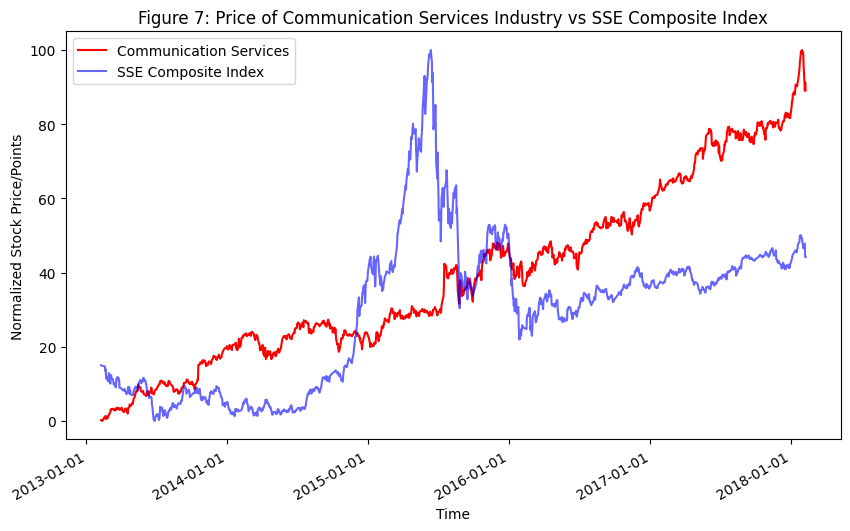

Correlation coefficient: 0.5480440053014061, p value: 1.1536171060737801e-143


In [187]:
sci_hist_data_path = "data\historical_stock_data\SCI.csv"

# Plot stock prices for each company
plt.figure(figsize=(10, 6))

sci_hist_data = pd.read_csv(sci_hist_data_path)
sci_hist_data["Date"] = pd.to_datetime(sci_hist_data["Date"])
full_date_range = pd.date_range(
    sci_hist_data["Date"].min(), sci_hist_data["Date"].max(), freq="D"
)

# Reindex the DataFrame to include all dates in the range
sci_hist_data = sci_hist_data.set_index("Date").reindex(full_date_range).reset_index()

# Fill missing values with the mean of the surrounding values
sci_hist_data["Close"] = sci_hist_data["Close"].interpolate().round(4)
closing_price_sci = sci_hist_data["Close"].values

normalized_cp_sci = min_max_normalize(closing_price_sci, 0, 100)

industry = "Communication Services"
CS_closing_prices = avg_closing_price_industry[10]
normalized_CS_cp = min_max_normalize(CS_closing_prices, 0, 100)

plt.plot(dates, normalized_CS_cp, label=industry, color="red")
plt.plot(dates, normalized_cp_sci, label="SSE Composite Index", color="blue", alpha=0.6)
correlation_coefficient, p_value = scipy.stats.pearsonr(normalized_CS_cp, normalized_cp_sci)

# Format x-axis as dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability


plt.title("Figure 7: Price of Communication Services Industry vs SSE Composite Index")
plt.xlabel("Time")
plt.ylabel("Normalized Stock Price/Points")
plt.legend()
plt.show()

print(f"Correlation coefficient: {correlation_coefficient}, p value: {p_value}")

In this chart I plot the historical data of the SSE Composite Index in blue and the price graph of the Communication Services industry of the S&P 500 in red. The SSE Composite Index tracks all stocks listed at the Shanghai stock exchange. We know that the crash of the chinese stock market in 2015 has led to the price fluctuations in the S&P 500. After calculating the correlation, we see that there exists a positive correlation between the two graphs. Because of the previously mentioned articles we know that this is not only a correlation but a causation. I have selected the Communication Services Industry graph here because the correlation is particularly visible. However also the other industries show a similarity to the SSE Composite Index graph to varying degrees.

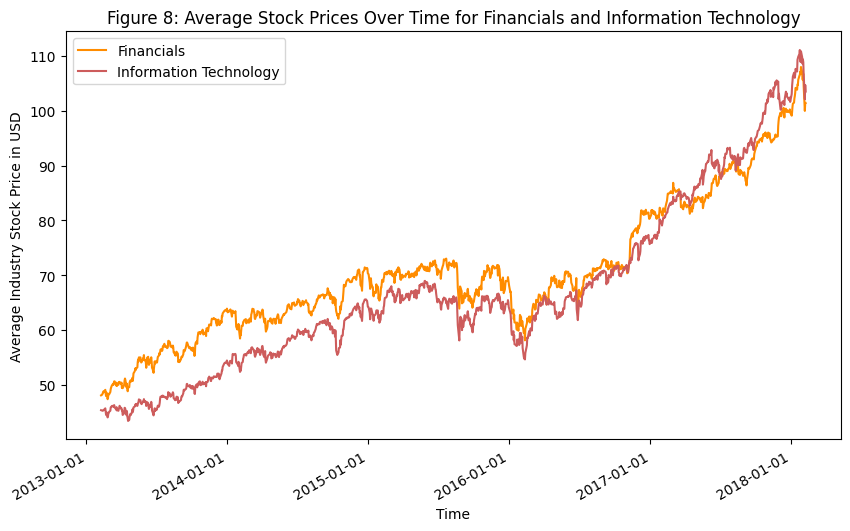

In [188]:
plt.figure(figsize=(10, 6))

for ind, industry in enumerate(industry_colors.keys()):
    if industry == "Financials" or industry == "Information Technology":
        plt.plot(
            dates,
            avg_closing_price_industry[ind],
            label=industry,
            color=industry_colors[industry],
        )

# Format x-axis as dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability

plt.title("Figure 8: Average Stock Prices Over Time for Financials and Information Technology")
plt.xlabel("Time")
plt.ylabel("Average Industry Stock Price in USD")
plt.legend()
plt.show()

Comparing the best (Financials) and the worst (Information Technology) industry directly is at first highly counterintuitive because both graphs look similar and also the return of both seems to be almost equal. That can also be observed in figure 3. However the big difference between the two industries is that the Financials industry had a really low volatility while the IT industry had a really high volatility. Because I factored in volatility in my measure of industry "goodness" the IT industry ended up performing the worse overall because of its high volatility. The difference in volatility is not easily observable in the line chart above as too many datapoints are plotted.

#### 4. Sub-question 3: What is the top performing company in each industry?

In this part I want to explore what the top performing company is in each industry. I do this to determine what the best investment would have been for each industry and how the average performance differs from the top performing company. This information is neccessary, in order to investigate whether a significantly better portfolio performance than the industry average could have been achieved through investment in a specific company in this industry instead of e.g. an industry Exchange Traded Fund (ETF) that covers all or almost all companies in the industry.

In [202]:
sp500_comp_ex = (
    sp500_companies_extended.copy()
)  # copy dataset for outlier removal

sp500_comp_ex["Avg_return_normalized"] = (
    sp500_comp_ex["Avg_return"] - sp500_comp_ex["Avg_return"].min()
) / (sp500_comp_ex["Avg_return"].max() - sp500_comp_ex["Avg_return"].min())

sp500_comp_ex["Std_dev_normalized"] = (
    sp500_comp_ex["Std_dev"] - sp500_comp_ex["Std_dev"].min()
) / (sp500_comp_ex["Std_dev"].max() - sp500_comp_ex["Std_dev"].min())

sp500_comp_ex["Stability_normalized"] = (
    1 - sp500_comp_ex["Std_dev_normalized"]
)  # calc stability score out of volatility

sp500_comp_ex["Average_Stability_Return"] = (
    sp500_comp_ex["Stability_normalized"] + sp500_comp_ex["Avg_return_normalized"]
) / 2 # Calculate the average of stability and return


industry_stats = sp500_comp_ex.groupby('GICS Sector').agg({
    'Avg_return_normalized': 'mean',
    'Stability_normalized': 'mean',
}).reset_index()

industry_stats['Mean_between_return_and_stability'] = (industry_stats['Avg_return_normalized'] + (industry_stats['Stability_normalized'])) / 2

# Find the index of the row with the highest metric in each industry
asr = sp500_comp_ex.groupby('GICS Sector')['Average_Stability_Return'].idxmax()
sn = sp500_comp_ex.groupby('GICS Sector')['Stability_normalized'].idxmax()
arn = sp500_comp_ex.groupby('GICS Sector')['Avg_return_normalized'].idxmax()

unique_industries = sp500_comp_ex['GICS Sector'].unique()
plot_data = {industry: None for industry in unique_industries}

index_series = [asr, sn, arn]
metric_list = ["Average_Stability_Return", "Stability_normalized", "Avg_return_normalized"]

extracted_data = [[],[],[]]

for i, series in enumerate(index_series):
    for industry, index in series.items():
        row = sp500_comp_ex.iloc[index]
        extracted_data[i].append(row) 

asr_data = []
sn_data = []
arn_data = []
for i, metric in enumerate(extracted_data):
    for company in metric:
        if i == 0:
            asr_data.append(company["Average_Stability_Return"])    
        if i == 1:
            sn_data.append(company["Stability_normalized"])
        if i == 2:
            arn_data.append(company["Avg_return_normalized"])

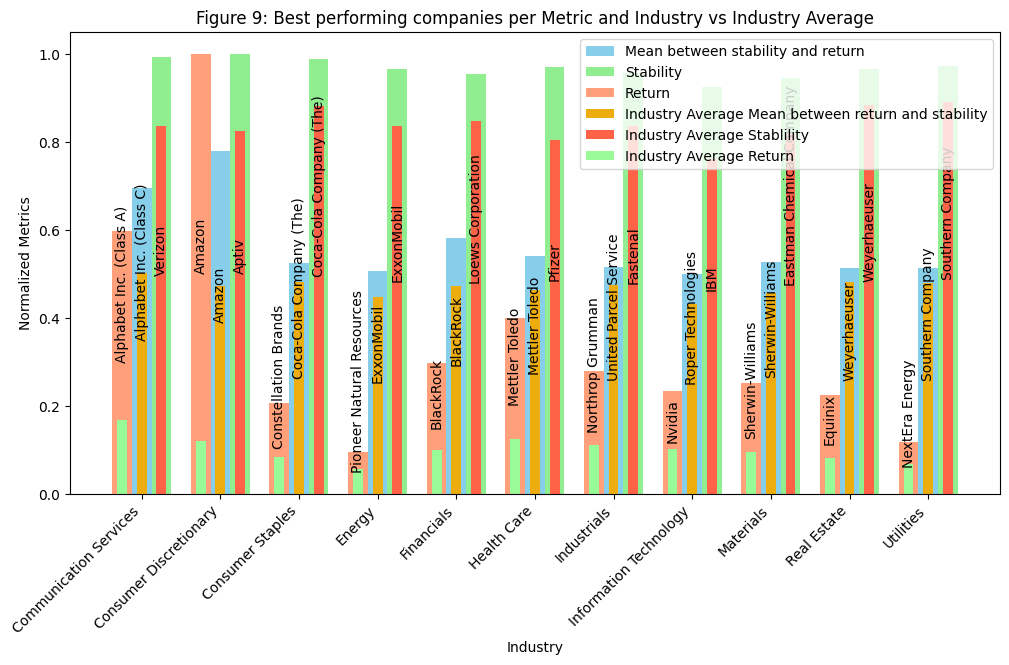

In [203]:

plt.figure(figsize=(12, 6))

bar_width = 0.25  # Width of each bar

# Create numerical positions for each industry
industries = np.arange(len(industry_stats["GICS Sector"]))

plt.bar(
    industries + 0.5*bar_width,
    asr_data,
    width=bar_width,
    label="Mean between stability and return",
    color="#87CEEB",
)

plt.bar(
    industries + 1.5*bar_width,
    sn_data,
    width=bar_width,
    label="Stability",
    color="#90EE90",
)

plt.bar(
    industries - 0.5*bar_width,
    arn_data,
    width=bar_width,
    label="Return",
    color="#FFA07A",
)

#############

plt.bar(
    industries + 0.5*bar_width,
    industry_stats["Mean_between_return_and_stability"],
    width=bar_width/2,
    label="Industry Average Mean between return and stability",
    color="#EEAD0E",
)

plt.bar(
    industries + 1.5*bar_width,
    industry_stats["Stability_normalized"],
    width=bar_width/2,
    label="Industry Average Stablility",
    color="#FF6347",
)

plt.bar(
    industries - 0.5*bar_width,
    industry_stats["Avg_return_normalized"],
    width=bar_width/2,
    label="Industry Average Return",
    color="#98FB98",
)

# Set x-axis ticks to industry names
plt.xticks(
    industries + bar_width / 2, industry_stats["GICS Sector"], rotation=45, ha="right"
)

for i, industry in enumerate(unique_industries):
    asr_company_name = extracted_data[0][i]["Security"]
    plt.text(industries[i] + 0.5 * bar_width, extracted_data[0][i]["Average_Stability_Return"] / 2, f"{asr_company_name}", ha='center', va='bottom' if extracted_data[0][i]["Average_Stability_Return"] >= 0 else 'top', rotation='vertical', color='black')
    
    sn_company_name = extracted_data[1][i]["Security"]
    plt.text(industries[i] + 1.5 * bar_width, extracted_data[1][i]["Stability_normalized"] / 2, f"{sn_company_name}", ha='center', va='bottom' if extracted_data[1][i]["Stability_normalized"] >= 0 else 'top', rotation='vertical', color='black')
    
    arn_company_name = extracted_data[2][i]["Security"]
    plt.text(industries[i] - 0.5 * bar_width, extracted_data[2][i]["Avg_return_normalized"] / 2, f"{arn_company_name}", ha='center', va='bottom' if extracted_data[2][i]["Avg_return_normalized"] >= 0 else 'top', rotation='vertical', color='black')


plt.title("Figure 9: Best performing companies per Metric and Industry vs Industry Average")
plt.xlabel("Industry")
plt.ylabel("Normalized Metrics")
plt.legend()
plt.show()


In this chart we can see the best performing companies in three different metrics for all industries. The bars are overlayed with the industry average in the respective industry. Through this, we can compare the best performing company with the industry average from the industry, the company operates in. This helps determining whether the industry contains companies that are significan outliers to what is normal in the respective industry. Looking at the chart above, we can see that the return of the best performing companies, especially in the Communication Services and the Consumer Discretionary industry is significantly higher than the industry average. In almost every industry it is at least 100% higher. Regarding stability and the mean between stability and return, the differences between industry average and best performing company are less pronounced. Here, the biggest differences are also foudn in the Communication Services and the Consumer Discetionary Industry. In the other industries the difference is not larger than around 15%. With this information we can deduct, that investing in certain companies, rather than investing broadly in the industry, could have signifcantly boosted portfolio return, especially in the Communicatoin Services and the Consumer Discretionary industries. However when considering stability or overall "goodness" (a combination of stability and return), the difference in investing broadly and investing in the top performing companies, is not as pronounced and would mostly entail an advantage of only around 10%, again with only the Communication Services and the Consumer Discretionary industries yielding a larger advantage of around 20% (in the combined score).

## Conclusion

I can conclude that i am nude

todo: hypothesis for questions?